<img src="http://boutiques.github.io/images/logo.png" alt="logo" width="60" align="left" style="padding:5px;"/>

# Boutiques tutorial


This tutorial will walk you through the main features of [Boutiques](http://boutiques.github.io). Boutiques is a framework to make tools Findable Accessible Interoperable and Reusable (FAIR). An overview of the framework and its capabilities is available [here](https://figshare.com/articles/fair-pipelines-poster_pdf/8143241), and a more complete description is [here](https://academic.oup.com/gigascience/article/7/5/giy016/4951979). The entry point for our documentation is http://github.com/boutiques.

## Getting Started

Boutiques is available as a Python module on `pip` and can be installed by simply typing `pip install boutiques`. Once Boutiques is installed, its Python and command-line APIs can be accessed through your new favourite command, _bosh_ (BOutiques SHell). _bosh_ provides an access point to all of the tools wrapped within Boutiques and has some --help text to keep you moving forward if you feel like you're getting stuck. You can check that it's correctly installed by simply typing `bosh version` in a command line:

In [1]:
%%bash
bosh version

0.5.20.post1


Help is available through `--help`:

In [8]:
%%bash
bosh --help || true
# "|| true" is just a trick to improve display in this notebook

usage: bosh [--help]
            [{create,data,evaluate,example,exec,export,import,invocation,pprint,publish,pull,search,test,validate,version}]

positional arguments:
  {create,data,evaluate,example,exec,export,import,invocation,pprint,publish,pull,search,test,validate,version}
                        
                                       BOUTIQUES COMMANDS
                        
                        TOOL CREATION
                        * create: create a Boutiques descriptor from scratch.
                        * export: export a descriptor to other formats.
                        * import: create a descriptor for a BIDS app or update a descriptor from \
                            an older version of the schema.
                        * validate: validate an existing boutiques descriptor.
                        
                        TOOL USAGE & EXECUTION
                        * example: generate example command-line for descriptor.
                        * pprint:

_bosh_ commands are also available as a Python API, where the same parameters as in the command line are passed as a list to function _bosh_:

In [3]:
from boutiques import bosh
bosh(["version"])

'0.5.20.post1'

This tutorial mostly uses the command line API. In case you are not familiar with the command line syntax, more specifically that of the [bash](https://www.gnu.org/software/bash) shell, you are encouraged to first follow the tutorial [here](https://www.shellscript.sh). We will also try to explain the command-line syntax throughout the tutorial as much as possible (pay attention to the comment strings in the code cells!). All the `bosh` commands are also available from a Python API.

## Tutorial outline

We will use brain extraction (BET) as a running example to illustrate Boutiques features. More specifically, we will go through the following steps:
* [Finding tools](#finding_tools)
* [Reusing tools](#reusing_tools)
* [Publishing tools](#publishing_tools) (including how to write a Boutiques descriptor)
* [Advanced features](#advanced_features)

## Finding tools
<a id="finding_tools"></a>

Perhaps someone has already described the tool you are looking for and you could reuse their work. For instance, if you are looking for a tool that does brain extraction (BET), try:

In [4]:
%%bash
bosh search bet

[ INFO ] Showing 1 of 1 results.
ID              TITLE    DESCRIPTION                                DOWNLOADS
zenodo.1482743  fsl_bet  Automated brain extraction tool for FSL           38


The _search_ command returns a list of identifiers for tools matching your query. You can use these identifiers in any bosh command transparently. Even better, these identifiers are [Digital Object Identifiers](https://www.doi.org) hosted on [Zenodo](http://zenodo.org), they will never change and can't be deleted!

Once you have identified candidate tools for your task, you can get more details about how they work using bosh _pprint_:

In [5]:
%%bash
bosh pprint zenodo.1482743 | head
# The `|` operator, pronounced "pipe", is a bash operator to link two commands.
# Here we use it to redirect the output of `bosh pprint` to the input of `head`, 
# a handy command to display only the first lines of a long text.


Tool name: fsl_bet (ver: 1.0.0)
Tool description: Automated brain extraction tool for FSL
Tags: domain: neuroinformatics, mri

Command-line:
  bet [INPUT_FILE] [MASK] [FRACTIONAL_INTENSITY] [VERTICAL_GRADIENT]
      [CENTER_OF_GRAVITY] [OVERLAY_FLAG] [BINARY_MASK_FLAG]
      [APPROX_SKULL_FLAG] [NO_SEG_OUTPUT_FLAG] [VTK_VIEW_FLAG]


Behind the scene, _bosh_ has downloaded the tool descriptor from Zenodo and has stored it in `~/.cache/boutiques` on your computer:

In [6]:
%%bash
head ~/.cache/boutiques/zenodo-1482743.json

{
    "tool-version": "1.0.0", 
    "name": "fsl_bet", 
    "author": "Oxford Centre for Functional MRI of the Brain (FMRIB)",
    "descriptor-url": "https://github.com/aces/cbrain-plugins-neuro/blob/master/cbrain_task_descriptors/fsl_bet.json",
    "command-line": "bet [INPUT_FILE] [MASK] [FRACTIONAL_INTENSITY] [VERTICAL_GRADIENT] [CENTER_OF_GRAVITY] [OVERLAY_FLAG] [BINARY_MASK_FLAG] [APPROX_SKULL_FLAG] [NO_SEG_OUTPUT_FLAG] [VTK_VIEW_FLAG] [HEAD_RADIUS] [THRESHOLDING_FLAG] [ROBUST_ITERS_FLAG] [RES_OPTIC_CLEANUP_FLAG] [REDUCE_BIAS_FLAG] [SLICE_PADDING_FLAG] [MASK_WHOLE_SET_FLAG] [ADD_SURFACES_FLAG] [ADD_SURFACES_T2] [VERBOSE_FLAG] [DEBUG_FLAG]", 
    "inputs": [
        {
            "description": "Input image (e.g. img.nii.gz)", 
            "value-key": "[INPUT_FILE]", 


You can use file paths or Zenodo IDs indifferently in all _bosh_ commands. This can be useful when you work offline. For instance:

In [7]:
%%bash
bosh pprint ~/.cache/boutiques/zenodo-1482743.json | head


Tool name: fsl_bet (ver: 1.0.0)
Tool description: Automated brain extraction tool for FSL
Tags: domain: neuroinformatics, mri

Command-line:
  bet [INPUT_FILE] [MASK] [FRACTIONAL_INTENSITY] [VERTICAL_GRADIENT]
      [CENTER_OF_GRAVITY] [OVERLAY_FLAG] [BINARY_MASK_FLAG]
      [APPROX_SKULL_FLAG] [NO_SEG_OUTPUT_FLAG] [VTK_VIEW_FLAG]


## Reusing tools
<a id='reusing_tools'></a>

It looks like we have found a tool that suits our needs -- now it's time to put it to work! The first step is to create an _invocation_ with your input values. We will use the test data in [data](./data), a sample from the [CoRR](http://fcon_1000.projects.nitrc.org/indi/CoRR/html) dataset. You can visualize the dataset as follows. Note that upon first invocation, NiftiWidget might raise a `FutureWarning` exception: re-runing the cell should make it disappear.

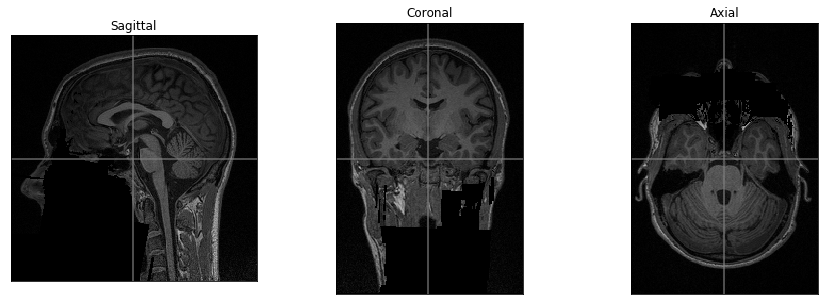

In [11]:
from niwidgets import NiftiWidget
my_widget = NiftiWidget('./data/test.nii.gz')
my_widget.nifti_plotter(colormap='gray')

The _example_ command will create a first minimal invocation so that you don't have to start from scratch:

In [12]:
%%bash
bosh example zenodo.1482743

{
    "infile": "f_infile_97.tex",
    "maskfile": "str_maskfile_jD"
}


If you feel like starting with a more complete set of options, you can pass `--complete` to the _example_ command:

In [13]:
%%bash
bosh example --complete zenodo.1482743

{
    "approx_skull_flag": true,
    "binary_mask_flag": true,
    "center_of_gravity": [
        -6.146,
        -46.492,
        -10.684
    ],
    "debug_flag": false,
    "fractional_intensity": 0.991,
    "head_radius": -2.001,
    "infile": "f_infile_98.csv",
    "maskfile": "str_maskfile_rH",
    "no_seg_output_flag": false,
    "overlay_flag": false,
    "robust_iters_flag": false,
    "thresholding_flag": true,
    "verbose_flag": true,
    "vg_fractional_intensity": -0.195,
    "vtk_mesh": true
}


You can now edit the example invocation to add your input values:

In [6]:
%%bash
cat example_invocation.json
# The cat command prints the content of a file.

{
	"infile": "./data/test.nii.gz",
        "maskfile": "test_brain.nii.gz"
}


You are now all set to use the _exec_ command to launch an analysis. One catch: we assume you have Docker or Singularity installed. A fair assumption, nowadays? We hope so:

In [ ]:
%%bash
bosh exec launch -s zenodo.1482743 ./example_invocation.json

You can check that the output file was created as expected:

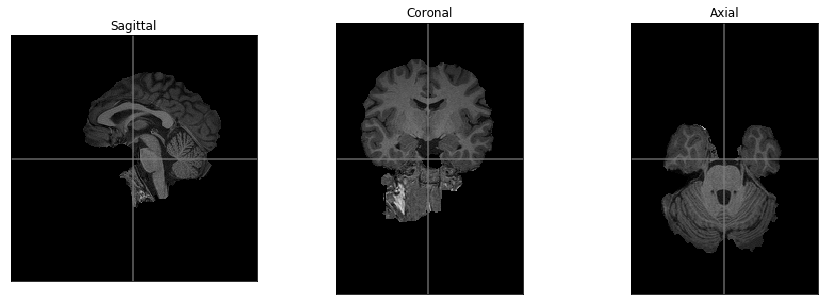

In [17]:
from niwidgets import NiftiWidget
my_widget = NiftiWidget('./test_brain.nii.gz')
my_widget.nifti_plotter(colormap='gray')

Of course, this can all be reproduced with the Python API, for instance:

In [18]:
from boutiques import bosh
out = bosh(["example", "zenodo.1482743"])
print(out)

{
    "infile": "f_infile_09.m",
    "maskfile": "str_maskfile_CZ"
}


And to integrate with Python programs even better, _descriptor2func_ can generate Python functions from descriptors. Here is an example that will run our BET tool:

In [ ]:
from boutiques.descriptor2func import function
fslbet = function("zenodo.1482743")
out = fslbet(infile="./data/test.nii.gz", maskfile="test_brain.nii.gz")
print(out)

You now have a Python API for Boutiques tools, regardless of their original programming language!

### Chaining tools

Boutiques doesn't prescribe any pipeline language or engine. Feel free to use whichever you want! In its simplest form, _descriptor2func_ makes it easy to chain tools in a Python program:

In [ ]:
from boutiques.descriptor2func import function
fslbet = function("zenodo.1482743")
fslstats = function("zenodo.3240521")
bet_out = fslbet(infile="./data/test.nii.gz", maskfile="test_brain.nii.gz")
stats_out = fslstats(input_file="test_brain.nii.gz", v=True)
! cat output.txt

## Publishing your own tool
<a id="publishing_tools"></a>

So far we have been referring to Boutiques tools through their IDs/DOIs. Tools are described in a structured format where the tool interface and installation are specified. A Boutiques tool descriptor is a JSON file that fully describes the input and output parameters and files for a given command line call (or calls, as you can include pipes(`|`) and ampersands (`&`)). To help you describe and publish your tool, we will walk through the process of making a tool descriptor for [FSL's BET](http://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET). The finished product is the one we used in the previous section (tool id: `zenodo.1482743`, also available as [fsl-bet-final.json](./fsl-bet-final.json)).

### Step 0: Tool containerization

A useful feature of Boutiques is its ability to refer to container images so that tools can be deployed transparently on multiple platforms. Although Boutiques can technically describe uncontainerized tools, we strongly recommend that you find or build a container image where your tool is available. Containers will make your work more reusable! 

In this tutorial, however, we won't be able to use containers as this notebook runs in Binder and Binder doesn't support running containers from notebooks.

### Step 1: Describing the command line

The first step in creating a tool descriptor for your command line call is creating a fully descriptive list of your command line options. If your tool was written in Python and you use the `argparse` library, then this is already done for you in large part. For many tools (bash, Python, or otherwise) this can be obtained by executing it with the `-h` flag. In the case of FSL BET, we get the following from our container image:

In [9]:
%%bash
bet -h || true
# "|| true" is just a trick to improve display in this notebook


Usage:    bet <input> <output> [options]

Main bet2 options:
  -o          generate brain surface outline overlaid onto original image
  -m          generate binary brain mask
  -s          generate approximate skull image
  -n          don't generate segmented brain image output
  -f <f>      fractional intensity threshold (0->1); default=0.5; smaller values give larger brain outline estimates
  -g <g>      vertical gradient in fractional intensity threshold (-1->1); default=0; positive values give larger brain outline at bottom, smaller at top
  -r <r>      head radius (mm not voxels); initial surface sphere is set to half of this
  -c <x y z>  centre-of-gravity (voxels not mm) of initial mesh surface.
  -t          apply thresholding to segmented brain image and mask
  -e          generates brain surface as mesh in .vtk format

Variations on default bet2 functionality (mutually exclusive options):
  (default)   just run bet2
  -R          robust brain centre estimation (iterates BE

Looking at all of these flags, we see a list of options which can be summarized by:
```
bet [INPUT_FILE] [MASK] [FRACTIONAL_INTENSITY] [VERTICAL_GRADIENT] [CENTER_OF_GRAVITY] [OVERLAY_FLAG] [BINARY_MASK_FLAG] [APPROX_SKULL_FLAG] [NO_SEG_OUTPUT_FLAG] [VTK_VIEW_FLAG] [HEAD_RADIUS] [THRESHOLDING_FLAG] [ROBUST_ITERS_FLAG] [RES_OPTIC_CLEANUP_FLAG] [REDUCE_BIAS_FLAG] [SLICE_PADDING_FLAG] [MASK_WHOLE_SET_FLAG] [ADD_SURFACES_FLAG] [ADD_SURFACES_T2] [VERBOSE_FLAG] [DEBUG_FLAG]
```

Now that we have summarized all command line options for our tool - some of which describe inputs and others, outputs - we can begin to craft our JSON Boutiques tool descriptor.

### Step 2: Understanding Boutiques + JSON

For those unfamiliar with JSON, we recommend following this [3 minute JSON tutorial](http://www.secretgeek.net/json_3mins) to get you up to speed. In short, a JSON file is a dictionary object which contains *keys* and associated *values*. A *key* informs us what is being described, and a *value* is the description (which, importantly, can be arbitrarily typed). The Boutiques tool descriptor is a JSON file which requires the following keys, or, properties:
- `name`
- `description`
- `tool-version`
- `schema-version`
- `command-line`
- `inputs`

Some additional, optional, properties that Boutiques will recognize are:
- `groups`
- `tool-version`
- `suggested-resources`
- `container-image`:
  - `type`
  - `image`
  - `index`

The complete list of properties and their description is available [here](https://github.com/boutiques/boutiques/tree/master/schema).
In the case of BET, we will of course populate the required elements, but will also include `groups` and `tags`.

### Step 3: Populating the tool descriptor

bosh command _create_ will help you start with a minimal descriptor:

In [20]:
%%bash
bosh create fsl-bet.json

This produced a template descriptor in [fsl-bet.json](./fsl-bet.json):

In [21]:
%%bash
head fsl-bet.json

{
    "command-line": "echo [PARAM1] [PARAM2] [FLAG1] > [OUTPUT1]",
    "container-image": {
        "image": "user/image",
        "index": "docker://",
        "type": "singularity"
    },
    "description": "tool description",
    "error-codes": [
        {


We will break-up populating the tool descriptor into two sections: adding meta-parameters (such as `name`, `description`, `schema-version`, `command-line`, and `tool-version`) and adding i/o-parameters (such as `inputs`, `output-files`, and `groups`).

#### Step 3.1: Adding meta-parameters

Many of the meta-parameters will be obvious to you if you're familiar with the tool, or extractable from the message received earlier when you passed the `-h` flag into your program. We can update properties `name`, `tool-version`, `description`, `container-image` and `command-line` in our JSON (see current descriptor in [fsl-bet-metadata.json](fsl-bet-metadata.json)):

In [10]:
%%bash
grep -P "fsl_bet|tool-version|Automated|command-line|image" fsl-bet-metadata.json
# grep is a useful command to find the lines in a text files that contain
# specific patters, here "fsl_bet" or "too-version" ... 
# Here we use it to show the relevant lines of file fsl-bet-metadata.json

    "command-line": "bet [INPUT_FILE] [MASK] [FRACTIONAL_INTENSITY] [VERTICAL_GRADIENT] [CENTER_OF_GRAVITY] [OVERLAY_FLAG] [BINARY_MASK_FLAG] [APPROX_SKULL_FLAG] [NO_SEG_OUTPUT_FLAG] [VTK_VIEW_FLAG] [HEAD_RADIUS] [THRESHOLDING_FLAG] [ROBUST_ITERS_FLAG] [RES_OPTIC_CLEANUP_FLAG] [REDUCE_BIAS_FLAG] [SLICE_PADDING_FLAG] [MASK_WHOLE_SET_FLAG] [ADD_SURFACES_FLAG] [ADD_SURFACES_T2] [VERBOSE_FLAG] [DEBUG_FLAG]",
    "description": "Automated brain extraction tool for FSL",
            "command-line-flag": "-f",
    "name": "fsl_bet",
    "tool-version": "1.0.0"


#### Step 3.2: Adding i/o parameters

Inputs and outputs of many applications are complicated - outputs can be dependent upon input flags, flags can be mutually exclusive or require at least one option, etc. The way Boutiques handles this is with a detailed schema which consists of options for inputs and outputs, as well as optionally specifying groups of inputs which may add additional layers of input complexity.

As you have surely noted, tools may have many input and output parameters. This means that inputs, outputs, and groups, will be described as a list. Each element of these lists will be a dictionary following the input, output, or group schema, respectively. 

In the following sections, we will show you the dictionaries responsible for output, input, and group entries. 

##### Step 3.2.1: Specifying inputs

The input schema contains several options, many of which can be ignored in this first example with the exception of `id`, `name`, and `type`. For BET, there are several input values we can choose to demonstrate this for you. We have chosen four with considerably different functionality and therefore schemas. In particular:
- `[INPUT_FILE]`
- `[MASK]`
- `[FRACTIONAL_INTENSITY]`
- `[CENTER_OF_GRAVITY]`

**`[INPUT_FILE]`**   The simplest of these is the `[INPUT_FILE]` which is a required parameter that simply expects a qualified path to a file. The dictionary entry is:
```
{
    "id" : "infile",
    "name" : "Input file",
    "type" : "File",
    "description" : "Input image (e.g. img.nii.gz)",
    "value-key" : "[INPUT_FILE]"
}
```

**`[MASK]`**   This parameter is a string from which the output mask file name will be defined. The dictionary entry is:
```
{
    "description": "Output brain mask (e.g. img_bet.nii.gz)", 
    "value-key": "[MASK]", 
    "type": "String", 
    "optional": false, 
    "id": "maskfile", 
    "name": "Mask file"
}
```

**`[FRACTIONAL_INTENSITY]`**   This parameter documents an optional flag that can be passed to the executable. Along with the flag, when it is passed, is a floating point value that can range from 0 to 1. We are able to validate at the level of Boutiques whether or not a valid input is passed, so that jobs are not submitted to the execution engine which will error, but they get flagged upon validation of inputs. This dictionary is:
```
{
    "id" : "fractional_intensity",
    "name" : "Fractional intensity threshold",
    "type" : "Number",
    "description" : "Fractional intensity threshold (0->1); default=0.5; smaller values give larger brain outline estimates",
    "command-line-flag": "-f",
    "optional": true,
    "value-key" : "[FRACTIONAL_INTENSITY]",
    "minimum" : 0,
    "maximum" : 1
}
```

**`[CENTER_OF_GRAVITY]`**   The center of gravity value expects a triple (i.e. [X, Y, Z] position) if the flag is specified. Here we are able to set the condition that the length of the list received after this flag is 3, by specifying that the input is a list that has both a minimum and maximum length.
```
{
    "id" : "center_of_gravity",
    "name" : "Center of gravity vector",
    "type" : "Number",
    "description" : "The xyz coordinates of the center of gravity (voxels, not mm) of initial mesh surface. Must have exactly three numerical entries in the list (3-vector).",
    "command-line-flag": "-c",
    "optional": true,
    "value-key" : "[CENTER_OF_GRAVITY]",
    "list" : true,
    "min-list-entries" : 3,
    "max-list-entries" : 3
}
```

For further examples of different types of inputs, feel free to explore [more examples](https://github.com/aces/cbrain-plugins-neuro/tree/master/cbrain_task_descriptors).

##### Step 3.2.2: Specifying outputs

The output schema also contains several options, with the only mandatory ones being `id`, `name`, and `path-template`. We again demonstrate an example from BET:
- `outfile`

**`outfile`**   All of the output parameters in BET are similarly structured, and exploit the same core functionality of basing the output file, described by `path-template`, as a function of an input value on the command line, here given by `[MASK]`. The `optional` flag also describes whether or not a derivative should always be produced, and whether Boutiques should indicate an error if a file isn't found. The output descriptor is thus:

```
{
    "id" : "outfile",
    "name" : "Output mask file",
    "description" : "Main default mask output of BET",
    "path-template" : "[MASK].nii.gz",
    "optional" : true
}
```

#### Step 3.2.3: Specifying groups

The group schema provides an additional layer of complexity when considering the relationships between inputs. For instance, if multiple inputs within a set are mutually exclusive, they may be grouped and a flag set indicating that only one can be selected. Alternatively, if at least one option within a group must be specified, the user can also set a flag indicating such. The following group from the BET implementation is used to illustrate this:
- `variational_params_group`

**`variational_params_group`**   Many flags exist in BET, and each of them is represented in the command line we specified earlier. However, as you may have noticed when reading the output of `bet -h`, several of these options are mutually exclusive to one another. In order to again prevent jobs from being submitted to a scheduler and failing there, Boutiques enables grouping of inputs and forcing such mutual exclusivity so that the invalid inputs are flagged in the validation stage. This group dictionary is:


```
{
    "id" : "variational_params_group",
    "name" : "Variations on Default Functionality",
    "description" : "Mutually exclusive options that specify variations on how BET should be run.",
    "members" : ["robust_iters_flag", "residual_optic_cleanup_flag", "reduce_bias_flag", "slice_padding_flag", "whole_set_mask_flag", "additional_surfaces_flag", "additional_surfaces_t2"],
    "mutually-exclusive" : true
}
```

#### Step 3.3: Specifying tags (optional)

You can also specify tags to help others find your tool once it's published:
```
"tags": {
        "domain": [ "neuroimaging", "mri" ]
        "toolbox": "fsl",
        "brain extraction": true
    }
```

#### Step 3.4: Extending the tool descriptor  (optional) 

Now that the basic implementation of this tool has been done, you can check out the [schema](https://github.com/boutiques/boutiques/tree/master/schema) to explore deeper functionality of Boutiques. For instance, you can specify `suggested-resources` to help platforms run your tool on HPC clusters or clouds.

### Alternate path: Creating descriptors from Python scripts

If you want a bit more of a head start and your tool is built in Python using the argparse library, you don't have to write your descriptor by hand! In the Python script with your argparser defined, simply add the following lines to get yourself a minimal corresponding descriptor:

```
import boutiques.creator as bc
newDescriptor = bc.CreateDescriptor(myparser, execname="/command/to/run/exec")
newDescriptor.save("my-new-descriptor.json")
```

There are additional custom arguments which can be supplied to this script, such as tags for your tool. It is also worth noting that no interpretation of output files is attempted by this tool, so your descriptor could certainly be enhanced by addind these and other features available through Boutiques, such as tests, tags, error codes, groups, and container images.

Once you've created your descriptor this way you can translate your arguments to a Boutiques-style invocation using the following code block:

```
args = myparser.parse_args()
invoc = newDescriptor.createInvocation(args)

# Then, if you want to save them to a file...
import json
with open('my-inputs.json', 'w') as fhandle:
    fhandle.write(json.dumps(invoc, indent=4))
```

### Step 4: Validating the tool descriptor

You just created a Boutiques descriptor - Congratulations! 
Now, you need to quickly validate it to make sure that you didn't accidentally break any rules in this definition (like requiring a "flag" input). You can validate your schema like this

In [23]:
%%bash
# here we use the final product of the FSL BET descriptor that is already published
bosh validate zenodo.1482743 

OK


Depending on the status of your descriptor, bosh will either tell you it's A-OK or tell you where the problems are and what you should fix. If you want to know more about some extra options packed into this validator, you can check them with `bosh validate -h`, as one may expect.

### Step 5: Checking the descriptor

You now have a valid tool descriptor, congratulations! It doesn't mean that it will do what you expect though. The _simulate_ command will help you check that the tool will generate meaningful command lines:

In [24]:
%%bash
# Command line without options
bosh exec simulate zenodo.1482743

Generated Command:
bet f_infile_33.j str_maskfile_gY                   


In [25]:
%%bash
# Command line with all options
bosh exec simulate -c zenodo.1482743

Generated Command:
bet f_infile_29.m str_maskfile_cK -f 0.02 -g -0.249 -c 37.906 9.888 38.441 -o  -s -n  -r 26.182 -t -R        


The filenames and parameters were generated randomly within the valid ranges specified in the descriptor. This specific command line may not run, but you should check that it corresponds to what you had in mind. If anything seems fishy, you can update your descriptor and ensure you're describing the command-line you want. If you had a particular set of inputs in mind, you could pass them in with the `-i` flag. Again, as I'm sure you've guessed, you can learn more here with `bosh exec simulate -h`.

You could now try to run the tool on actual data, as explained in Section [Reusing tools](#reusing_tools). 

### Step 6: Publishing the descriptor

Now that you have checked that your descriptor works as intended, it's time to publish it so that others can reuse it. To do that, you will first have to create an account on [Zenodo](http://zenodo.org), the publishing platform used by Boutiques. Once your Zenodo account is created, you should create an application token in the "Applications" menu so that _bosh_ can publish descriptors under your name:

<img src="./images/zenodo-account.png"/>

Write down the access token that you have created, you will need it during publication.

You are now all set to publish your descriptor! Be careful though: once it's published, there won't be any way to remove it, although you will be able to update it. If you want to try a dry-run publication, you can use option `--sandbox` of the _publish_ command. It will require that you create an account on Zenodo's [sandbox](https://sandbox.zenodo.org) and create an access token for it.

In the example below, we use a common sandbox token:

In [26]:
%%bash
# Assuming you have saved your tool in fsl-bet-final.json
# Option -y answers 'yes' to all questions asked during publication
bosh publish --sandbox -y --zenodo-token 5EvAz78stQAb3uGn28IyC6Ovjer0GsHpLfd2aumJVuIReGmed3Mo0YjAgntr fsl-bet-final.json

10.5072/zenodo.295262


Hooray, your tool is now published! It is now being shared in a packaged and fully described fashion, making it easier than ever to reproduce and extend your work! As always, learn more about this feature with `bosh publish -h`.

You can find your tool the usual way:

In [27]:
%%bash
bosh search --sandbox fsl

[ INFO ] Showing 10 of 12 results.
ID             TITLE                       DESCRIPTION                                    DOWNLOADS
zenodo.246085  PreFreeSurferPipelineBatch  PreFreeSurferPipelineBatch HCP pipeline                0
zenodo.264108  FNIRT                       FNIRT, as implemented in Nipype (module:...            0
zenodo.265109  fsl_fast                    FAST (FMRIB's Automated Segmentation Too...            0
zenodo.295207  tool name                   tool description                                       0
zenodo.295262  fsl_bet-test                Automated brain extraction tool for FSL                0
zenodo.242580  Example Boutiques Tool      This property describes the tool or appl...            0
zenodo.252521  fsl_first                   FIRST is a model-based segmentation and ...            0
zenodo.246081  fsl_probtrackx2             probabilistic tracking with crossing fib...            0
zenodo.263338  FLIRT                       FLIRT, as implemented 

Check that your tool DOI shows in the list.

## Advanced features
<a id="advanced_features"></a>

### Evaluate Your Usage

If you've been using your tool and forget what exactly that output file will be named, or if it's optional, but find re-reading the descriptor a bit cumbersome, you should just evaluate your invocation. If we wanted to check the location of our output corresponding to the id `outfile`, we could do the following query:

In [28]:
%%bash
bosh evaluate zenodo.1482743 ./example_invocation.json output-files/id=outfile

{'outfile': 'test_brain.nii.gz.nii.gz'}


### Execution Records

Want to check up on what happened during a previous analysis? The details of each execution are captured and recorded in a publicly safe format so that you can review past analysis runs. These records are stored in the Boutiques cache and capture each executions' descriptor, invocation and output results. Input and output file hashes are included to easily compare results between different analyses. `bosh data` is the command to interact and publish execution records. For instance, here is the record for one of your runs:

In [29]:
%%bash
bosh data inspect -e

{
    "summary": {
        "name": "fsl_bet",
        "descriptor-doi": "10.5281/zenodo.1482743",
        "date-time": "2019-06-09T10:52:45.250677"
    },
    "public-invocation": {
        "infile": {
            "file-name": "test.nii.gz",
            "md5sum": "9daa5cff15e633a044b0df44a626abe1"
        },
        "maskfile": "test_brain.nii.gz"
    },
    "public-output": {
        "stdout": null,
        "stderr": null,
        "exit-code": 127,
        "error-message": "",
        "shell-command": "bet ./data/test.nii.gz test_brain.nii.gz                   ",
        "missing-files": {},
        "output-files": {}
    }
}
OK


Don't worry though, nothing gets public until you explicitly do so by running `bosh data publish`:

In [30]:
%%bash
bosh data publish --sandbox -y

[ INFO ] File fsl_bet_2019-06-09T10:52:45.250677.json has been removed from the data cache
[ INFO ] File fsl_bet_2019-06-09T04:47:05.050745.json has been removed from the data cache
[ INFO ] File fsl_bet_2019-06-09T10:52:04.202341.json has been removed from the data cache
OK


## Epilogue

That's the end of this tutorial, we hope you enjoyed it. Don't hesitate to leave us feedback by submitting an issue at https://github.com/boutiques/boutiques-tutorial, we'd love to improve this material!
